This notebook documents the calculation of the dark matter impulse differential rate $dR/dq$ with massless mediator.

In [12]:
import sys, os

import numpy as np
from scipy.special import erf

import matplotlib.pyplot as plt

## Parameters

In [4]:
hbarc = 0.2     # eV um
rho_T = 2.0e3   # Sphere density, kg/m^3
mAMU = 1.66e-27 # Neutron mass

In [5]:
R_um = 5          # Sphere radius, um
R = R_um / hbarc  # Radius in natural units, eV^-1

N_T = 0.5 * ( 4/3 * np.pi * (R_um*1e-6)**3) * rho_T/mAMU # Number of neutrons
res = 170e6       # detector resolution in eV

q_thr = 0.05e9    # momentum threshold, eV

DM parameters

In [6]:
M_X_in = 5e3         # GeV
alpha_n_in = 1e-8    # Gev
m_phi = 0            # Mediator mass, eV

In [14]:
M_X = M_X_in * 1e9   # Dark matter nugget mass, eV (assumes mass in GeV given on command line)
m_chi = 0.01 * 1e9   # eV
N_chi = M_X / m_chi  # Number of dark matter particles in the nugget

rhoDM = 0.3e9        # dark matter mass density, eV/cm^3
mR = m_phi * R        # (= R/lambda), a useful length scale; now defiend in `vtot()`

alpha_n = alpha_n_in # Dimensionless single neutron-nugget coupling
alpha = alpha_n * N_T # Coupling of the entire sphere

Some parameters related to DM velocity distribution.

In [8]:
vmin = 5e-5      # minimum velocity to consider, natural units (c)
vesc = 1.815e-3  # galactic escape velocity
v0 = 7.34e-4     # v0 parameter from Zurek group paper
ve = 8.172e-4    # ve parameter from Zurek group paper

In [209]:
alpha * ve / 1

2577.6199964995767

## DM velocity distribution $f(v)$
There are two choices for velocity distribution:

1. Asymmetric DM nugget:
https://arxiv.org/pdf/1812.07573.pdf .
See Eq. (32) and (33) of the paper. Note there is a typo in the sign of the exponential.
2. Standard halo model, which is a truncated Maxwell distribution.

We will just use the standard halo model for calculation considering a generic composite DM.

In [9]:
def f_halo(v):
    """
    DM velocity distribution in the Earth frame
    
    :param v: input velocity (array-like)
    :return: velocity distribtuion (array-like)
    """
    N0 = np.pi**1.5 * v0**3 * ( erf(vesc/v0) - 2/np.sqrt(np.pi) * (vesc/v0) * np.exp(-(vesc/v0)**2))
    
    # v < (vesc - ve)
    f1 = np.exp( - (v+ve)**2 / v0**2 ) * (np.exp(4*v*ve / v0**2) - 1)
    # (vesc - ve) < v < (vesc + ve)
    f2 = np.exp( - (v-ve)**2 / v0**2 ) - np.exp(- vesc**2 / v0**2)

    f = np.zeros_like(v)
    g1 = v < (vesc - ve)
    g2 = np.logical_and( vesc-ve < v, v < vesc + ve)
    
    f[g1] = f1[g1]
    f[g2] = f2[g2]

    return f * np.pi * v * v0**2 / (N0 * ve)

def f_halo_dan(v):
    """
    I think this is the 1-D standard halo model but need to double check.
    See Eq. (2) of https://link.aps.org/doi/10.1103/PhysRevD.42.3572
    """
    N0 = np.pi**1.5 * v0**3 * ( erf(vesc/v0) - 2/np.sqrt(np.pi) * (vesc/v0) * np.exp(-(vesc/v0)**2))
    return 4 * np.pi * v**2 * np.exp(-v**2 / v0**2) / N0

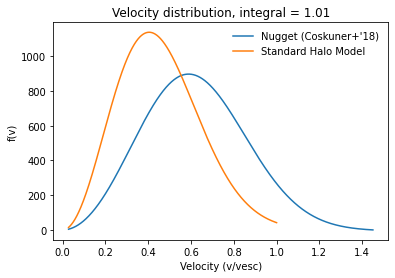

In [13]:
# Plot the DM velocity distribution
nvels = 2000
vels = np.linspace(vmin, vesc + ve, nvels)
vels_shm = np.linspace(vmin, vesc, nvels)

plt.figure()
plt.plot(vels/vesc, f_halo(vels), label='Nugget (Coskuner+\'18)')
plt.plot(vels_shm/vesc, f_halo_dan(vels_shm), label='Standard Halo Model')

plt.title(f'Velocity distribution, integral = {np.trapz(f_halo_dan(vels), vels):.2f}')
plt.legend(frameon=False)
plt.xlabel('Velocity (v/vesc)')
plt.ylabel('f(v)')
plt.show()

## DM scattering rate

The exact scattering cross section for point-like Yukawa potential $V(r) = (\alpha/r) e^{- m_\phi r}$ is given by

$$
\begin{equation}
\begin{aligned}
    \frac{d\sigma}{d \Omega} 
    &= \frac{ 4 m^2 \alpha^2}{ (m^2_\phi + q^2)^2 }, \\
    &= \frac{4 m^2 \alpha^2}{ (m^2_\phi + 4 p^2 \sin^2 \theta /2 )^2}.
\end{aligned}
\end{equation}
$$

In [89]:
def dsig_domega(mx, mphi, alpha, q):
    return ( 4 * (mx**2) * (alpha**2) ) / ( (mphi**2 + q**2)**2 )

In [58]:
q = np.logspace(6, 10, 1000)
dsigdomega = dsig_domega(M_X, m_phi, alpha, q)

Text(0, 0.5, '$d sigma / d \\Omega$')

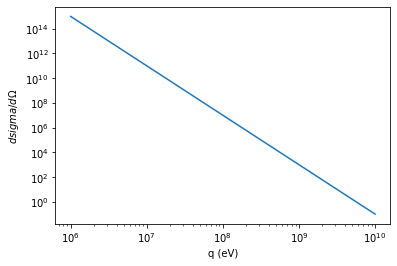

In [59]:
# Expect Rutherford cross section ~ 1 / (q^4)
plt.loglog(q, dsigdomega)
plt.xlabel('q (eV)')
plt.ylabel('$d sigma / d \Omega$')

Integrate over phase space for event rate $dR /dq$.

Convert to $d\sigma / dq$ by 
\begin{equation}
    \frac{d \sigma}{d q} = \frac{2 \pi q}{p^2} \frac{d \sigma}{d \Omega}.
\end{equation}

In [60]:
nvels = 200
vlist = np.linspace(vmin, vesc, nvels)

In [61]:
ss = np.empty(shape=(vlist.size, q.size))

for i, v in enumerate(vlist):
    p = M_X * v
    dsigdq = ( 2*np.pi*q / (p**2) ) * dsigdomega
    
    # Cut off contribution below detection threshold
    dsigdq[q < q_thr] = 0
    
    # Events outside of sphere only
    Ecm = 0.5 * M_X * v**2
    k = alpha_n * N_T   # 4pi is already in the def of alpha
    bmin = 5e-4 / hbarc # 5 um radius
    qmax = 2 * M_X * v / np.sqrt(4 * Ecm**2 * bmin**2 / k**2 + 1)
    #dsigdq[q > qmax] = 0
    
    # Account for vmin at a given q
    dsigdq[q > 2 * M_X * v] = 0
    
    ss[i] = dsigdq

In [62]:
int_vec = rhoDM / M_X * vlist * f_halo(vlist)
drdq = np.empty_like(q)

for i in range(nvels):
    drdq[i] = np.trapz( int_vec * ss.T[i], x=vlist )

Text(0, 0.5, 'dR/dq (counts / hr / GeV)')

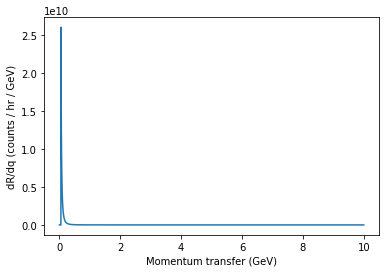

In [64]:
conv_fac = hbarc**2 * 1e9 * 3e10 * 1e-8 * 3600  # natural units -> um^2/GeV, c [cm/s], um^2/cm^2, s/hr

plt.plot(q/1e9, drdq * conv_fac)
plt.xlabel('Momentum transfer (GeV)')
plt.ylabel('dR/dq (counts / hr / GeV)')

Now generalize to arbitrary DM mass and coupling.

In [196]:
def dR_dq(mx, mphi, alpha, q, vlist, q_thr):
    # Differential cross section
    dsigdomega = dsig_domega(mx, mphi, alpha, q)
    
    # Integrate over phase space
    ss = np.empty(shape=(vlist.size, q.size))
    for i, v in enumerate(vlist):
        p = mx * v
        dsigdq = ( 2*np.pi*q / (p**2) ) * dsigdomega

        # Cut off contribution below detection threshold
        dsigdq[q < q_thr] = 0

        # Events outside of sphere only
        # Not using this at the moment, assume sphere as perfect point particle
        Ecm = 0.5 * mx * v**2
        k = alpha_n * N_T   # 4pi is already in the def of alpha
        bmin = 5e-4 / hbarc # 5 um radius
        qmax = 2 * mx * v / np.sqrt(4 * Ecm**2 * bmin**2 / k**2 + 1)
        dsigdq[q > qmax] = 0

        # Account for vmin at a given q
        dsigdq[q > 2 * mx * v] = 0

        ss[i] = dsigdq
        
    int_vec = rhoDM / mx * vlist * f_halo_dan(vlist)
    drdq = np.empty_like(q)

    for i in range(nvels):
        drdq[i] = np.trapz( int_vec * ss.T[i], x=vlist )
        
    conv_fac = hbarc**2 * 1e9 * 3e10 * 1e-8 * 3600  # natural units -> um^2/GeV, c [cm/s], um^2/cm^2, s/hr
    
    # Counts/hour/GeV
    return drdq * conv_fac

In [197]:
q = np.logspace(6, 10, 1000) # eV

nvels = 1000
vlist = np.linspace(vmin, vesc, nvels)

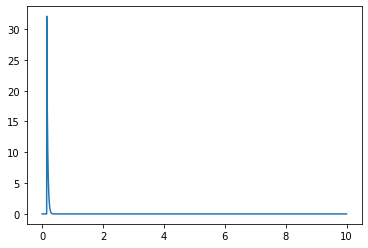

In [205]:
q_thr = 0.15e9
drdq = dR_dq(100*1e9, 0, alpha/(4*np.pi), q, vlist, q_thr)

plt.plot(q/1e9, drdq)
# plt.xscale('log')